In [23]:
modelType = "my-model-FilteredDeepLSTM" # "model-RNN"

In [ ]:
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/GoogleCommandsRepository.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/RNNModels.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/SequenceGenerator.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/audioUtils.py
!wget -q https://raw.githubusercontent.com/DeNatur/RNNSpeechCommands/main/requirements.txt
!pip install -r requirements.txt

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15287799506284566966
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 116514503375252631
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10152799644462510702
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1702731363243240671
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import GoogleCommandsRepository
import SequenceGenerator
# import RNNModels
from RNNModels import RNNSpeechModel, AttRNNSpeechModel, my_RNNSpeechModel, my2_SimpleRNNSpeechModel

In [4]:
# Download and prepare all data
gscInfo, nCategs = GoogleCommandsRepository.PrepareGoogleSpeechCmd(task='35word')

Done preparing Google Speech commands dataset


In [ ]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SequenceGenerator.SequenceGenerator(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SequenceGenerator.SequenceGenerator(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SequenceGenerator.SequenceGenerator(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SequenceGenerator.SequenceGenerator(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

In [6]:
audios, classes = valGen.__getitem__(5)
classes

array([21,  2, 28, 27, 18, 16, 11, 16, 22,  3, 12, 24, 12, 14, 20,  2, 29,
        8, 12, 25,  5, 16, 34,  3, 17,  5, 12, 19, 12,  5,  7, 32])

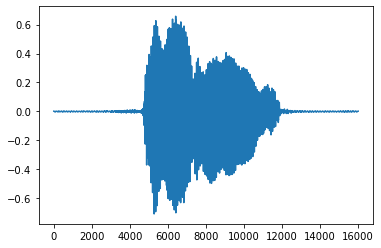

In [7]:
plt.plot(audios[4])

In [27]:
audios.shape

(32, 16000)

In [7]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers as Layers
from tensorflow.keras import backend as K


In [9]:
from kapre.utils import Normalization2D

In [39]:
#self-attention LSTM
#nCategs=36
sr=16000
iLen=16000
#from keras import layers as L

# ### Model z atencja
# if modelType != "model-attRNN":
#     model = AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
# else:
# ### Model bez atencji
#     model = RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

### My Model
model = Sequential()
model.add(Layers.Reshape((1, -1)))
model.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
               padding='same', sr=sr, n_mels=80,
               fmin=40.0, fmax=sr / 2, power_melgram=1.0,
               return_decibel_melgram=True, trainable_fb=False,
               trainable_kernel=False,
               name='mel_stft'))
model.add(Normalization2D(int_axis=0))

model.add(Layers.Conv2D(32, (5, 1), activation='relu', padding='same'))
model.add(Layers.BatchNormalization())
model.add(Layers.ReLU())
model.add(Layers.Dropout(0.2))

model.add(Layers.Conv2D(16, (5, 1), activation='relu', padding='same'))
model.add(Layers.BatchNormalization())
model.add(Layers.ReLU())
model.add(Layers.Dropout(0.2))

model.add(Layers.Conv2D(1, (5, 1), activation='relu', padding='same'))
model.add(Layers.Conv2D(filters=1, kernel_size=(5, 1), activation='relu'))
model.add(Layers.BatchNormalization())

model.add(Layers.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim'))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.LSTM(64, return_sequences=True))
model.add(Layers.Flatten())
model.add(Layers.Dense(64, activation='relu'))
model.add(Layers.Dense(32, activation='relu'))
model.add(Layers.Dense(nCategs, activation='softmax'))

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
# model.summary()

In [40]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [41]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [42]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(modelType + ".h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=8, verbose=2,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save(modelType + ".h5")

Changing learning rate to 0.001
Epoch 1/60


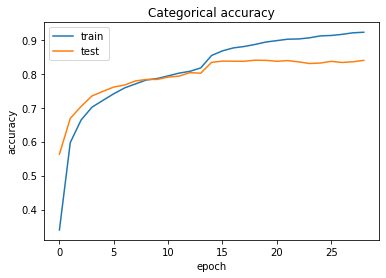

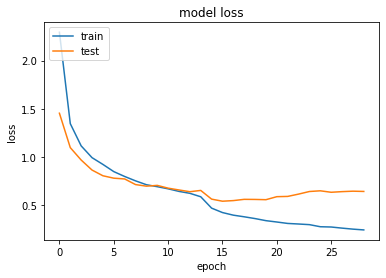

In [17]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# load best model according to cross-validation - model-attRNN
# model = load_model(modelType + ".h5", custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights(modelType + ".h5")

ValueError: Shapes (1, 256) and (125, 256) are incompatible

In [19]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [19]:
x_test.shape

(11005, 16000)

In [21]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

MemoryError: Unable to allocate 672. MiB for an array with shape (11005, 16000) and data type float32

In [11]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [21]:
import pandas as pd
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.3.4', '0.2.0', '1.3.5', '0.9.1']

# Save model to .pb

In [37]:
#model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)
#model.load_weights(modelType + ".h5")

model = load_model(modelType + ".h5", custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [22]:
tf.saved_model.save(model, modelType + "/1/")


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
